In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
import sys
sys.path.insert(0, op.dirname(os.getcwd()))

# python libs
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

# custom libs
from ttide.t_tide import t_tide
from ttide.t_predic import t_predic

# tk libs
from lib.objs.tkpaths import Site
from lib.io.aux_nc import StoreBugXdset as sbxds
from lib.plotting.tides import Plot_AstronomicalTide, Plot_ValidateTTIDE

# TODO: ACTUALIZAR A LIBRERIA UTIDE
# https://www.eoas.ubc.ca/~rich/#T_Tide


# --------------------------------------
# Site paths and parameters
site = Site('KWAJALEIN')

DB = site.pc.DB                        # common database
ST = site.pc.site                      # site database
PR = site.params                       # site parameters

# input files
p_astro_fit = ST.TIDE.hist_astro

# output files
p_astro_sim = ST.TIDE.sim_astro

# Simulation dates
d1_sim = np.datetime64(PR.SIMULATION.date_ini)
d2_sim = np.datetime64(PR.SIMULATION.date_end)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  import sys


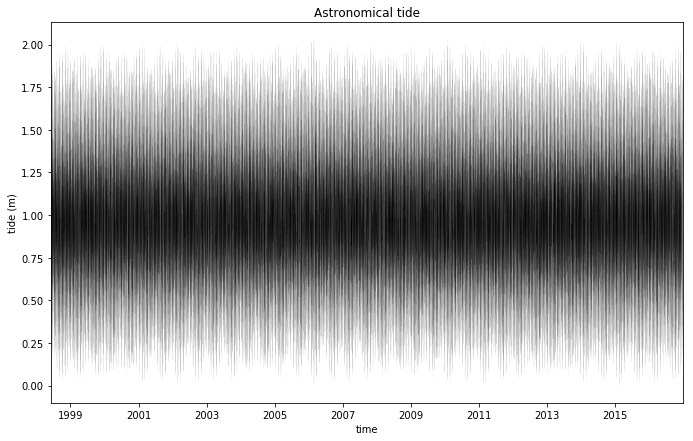

In [3]:
# --------------------------------------
# load astronomical tide data
xds_atide = xr.open_dataset(p_astro_fit)
xds_atide.rename(
    {'observed':'level',
     'predicted':'tide',
    }, inplace=True)

# remove tide nanmin
xds_atide['tide'] = xds_atide.tide - np.nanmin(xds_atide.tide)

# data length has to be lesser than 18.6 years
dt_cut = np.datetime64('1998-06-01')
xds_atide = xds_atide.where(xds_atide.time >= dt_cut, drop=True)

# Plot astronomical tide
time = xds_atide.time.values[:]
tide = xds_atide.tide.values[:]
Plot_AstronomicalTide(time, tide)


In [4]:
# --------------------------------------
# t_tide library - Fit

# TODO: ttide ha de se calibrada con un year de datos (no 18.6)
lat0 = 9.75
d_out = t_tide(xds_atide.tide.values, dt=1, lat=np.array(lat0))

# variables used for prediction
names = d_out['nameu']
freq = d_out['fu']
tidecon = d_out['tidecon']

/usr/local/lib/python2.7/site-packages/ttide-0.3_exp-py2.7.egg/ttide/t_tide.py:295: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(tc[gd, :], xin[gd])[0].T


-----------------------------------
nobs = 162936 
ngood = 162935 
record length (days) = 6789.00
rayleigh criterion = 1.0

Phases at central time
x0= 0.954  xtrend= 0
var(data)= 0.17    var(prediction)= 0.17    var(residual)= 0.00
var(prediction)/var(data) (%) = 99.6

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
  SA    0.0001141     0.0000     0.000     84.27    253.25   0.00046
  SSA   0.0002282     0.0000     0.000    325.95    251.10   0.00023
  MSM   0.0013098     0.0000     0.000    239.18    271.71   0.00056
* MM    0.0015122     0.0070     0.000    180.43      3.31   3.2e+02
  MSF   0.0028219     0.0000     0.000    267.56    249.64    0.0065
* MF    0.0030501     0.0113     0.000    281.19      1.88   8.2e+02
  ALP1  0.0343966     0.0000     0.000     57.77    282.13   0.00012
* 2Q1   0.0357064     0.0015     0.001    245.28     23.71       4.3
  SIG1  0.0359087     0.0000     0.000    209.84    273

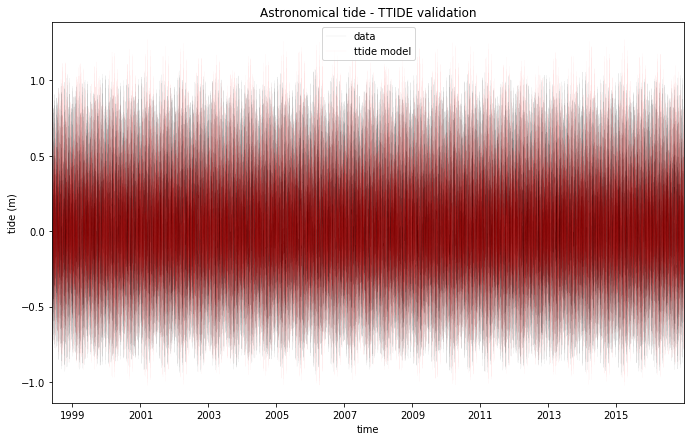

In [6]:
# --------------------------------------
# t_tide library - Validation

d1_val = xds_atide.time.values[0]
d2_val = xds_atide.time.values[-1]
date_val = np.arange(d1_val, d2_val, dtype='datetime64[h]')
tide_tt = t_predic(
    date_val, names, freq, tidecon,
    lat=lat0, ltype='nodal')

# Plot ttide validation 
time = xds_atide.time.values[:-1]
tide = xds_atide.tide.values[:-1]
tide = tide - np.nanmean(tide)
Plot_ValidateTTIDE(time, tide, tide_tt)



Astronomical Tide Simulation stored at:
/Users/ripollcab/Projects/TESLA-kit/source/teslakit/data/sites/KWAJALEIN/TIDE/tide_astro_sim.nc



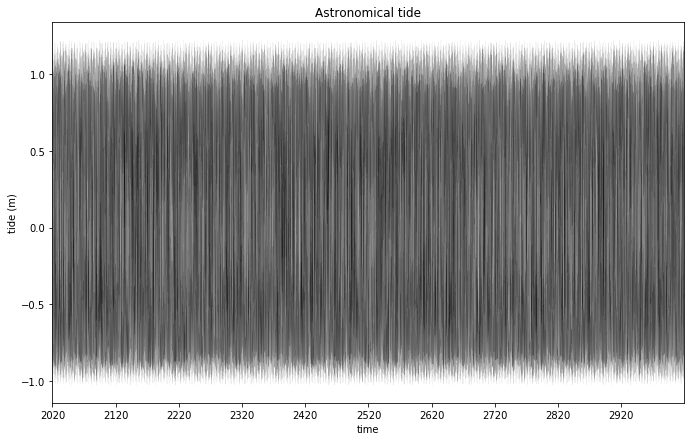

In [9]:
# --------------------------------------
# t_tide library - Prediction
date_pred = np.arange(d1_sim, d2_sim, dtype='datetime64[h]')
atide_pred = t_predic(
    date_pred, names, freq, tidecon,
    lat=lat0, ltype='nodal')

# Store data
dt_pred = [d.astype(datetime) for d in date_pred]
xds_atide_sim = xr.Dataset(
    {
        'tide'   :(('time',), atide_pred),
    },
    {'time' : dt_pred}
)

# xarray.Dataset.to_netcdf() wont work with this time array and time dtype
sbxds(xds_atide_sim, p_astro_sim)
print('\nAstronomical Tide Simulation stored at:\n{0}\n'.format(p_astro_sim))

# Plot astronomical tide prediction
time = xds_atide_sim.time.values[:]
tide = xds_atide_sim.tide.values[:]
Plot_AstronomicalTide(time, tide)
